# Laboratory #11 (2) : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constants

*   Change the path of the directories according to your drive location.

In [146]:
import os

root_path = r'/content/drive/MyDrive/P11_image_segmentation/TrayDataset'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [147]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 10

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [148]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

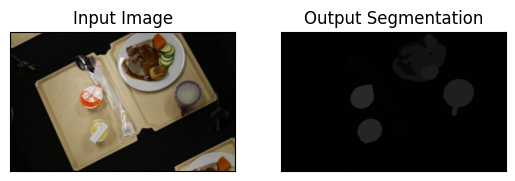

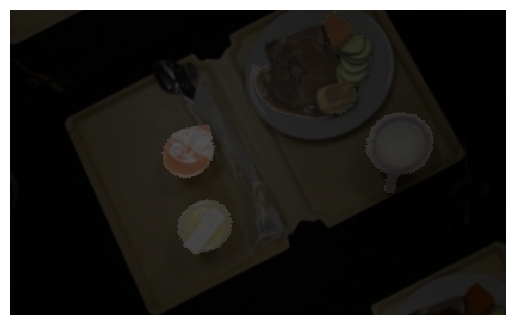

In [149]:
# solution

# *   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Display input image #7
plt.subplot(121)
plt.imshow(Image.open(train_img_paths[6]))
plt.title("Input Image")
plt.xticks([])
plt.yticks([])
# Display output segmentation #7
plt.subplot(122)
plt.imshow(Image.open(train_mask_paths[6]))
plt.title("Output Segmentation")
plt.xticks([])
plt.yticks([])
plt.show()

# *   Also, show the mask overlayed on the original image.


def mask_overlay(image, mask):
    """
    Helper function to visualize mask overlay on the image.
    """
    mask = np.ma.masked_where(mask == 0, mask)
    plt.imshow(image, "gray")
    plt.imshow(mask, "jet", interpolation="none", alpha=0.8)
    plt.axis("off")



mask_overlay(np.array(Image.open(train_img_paths[6])), np.array(Image.open(train_mask_paths[6])))


In [150]:
import tensorflow as tf

In [151]:
tf.test.is_gpu_available()

True

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

(-0.5, 415.5, 255.5, -0.5)

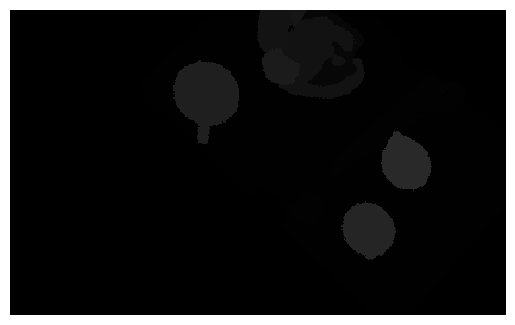

In [152]:
mask = np.array(Image.open(train_mask_paths[9]))
plt.imshow(mask, "jet", interpolation="none")
plt.axis("off")

In [153]:
np.unique(mask)

array([ 0,  1,  2,  7, 18, 19, 22, 27, 31, 37, 41], dtype=uint8)

In [154]:
# solution

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical


class ImageGenerator(Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)

        return x, y



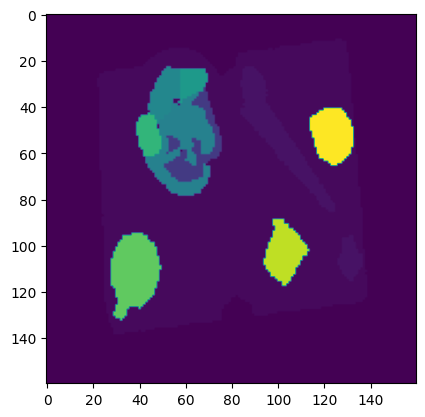

In [155]:
val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)
plt.imshow(val_gen[0][1][0].astype("uint8"))

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [179]:
from tensorflow.keras import layers
from tensorflow import keras

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [180]:
# Free up RAM in case the model definition cells were run multiple times

import keras
keras.backend.clear_session()

In [181]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [182]:
# solution

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [183]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

validation_size = 247
# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

# val_gen = ImageGenerator(batch_size, img_size, train_img_paths[-validation_size:], train_mask_paths[-validation_size:])

In [184]:
train_gen[0][0].shape

(32, 160, 160, 3)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [185]:
# solution

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")



*   Instantiate a ModelCheckpoint callback to save only the best model

In [186]:
# solution

callbacks = [
    keras.callbacks.ModelCheckpoint("tray_segmentation.h5")
]


*   Train the model using fit method

In [189]:
# solution

# *   Train the model using fit method

epochs = 25  # @param {type: "slider", min:8, max:80}
history = model.fit(train_gen, epochs=epochs, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 1.9154

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 16s 180ms/step - loss: 1.9154
Epoch 2/25
38/38 [==============================] - 8s 218ms/step - loss: 0.6192
Epoch 3/25
38/38 [==============================] - 7s 180ms/step - loss: 0.4395
Epoch 4/25
38/38 [==============================] - 8s 213ms/step - loss: 0.3367
Epoch 5/25
38/38 [==============================] - 7s 182ms/step - loss: 0.2527
Epoch 6/25
38/38 [==============================] - 8s 208ms/step - loss: 0.2410
Epoch 7/25
38/38 [==============================] - 7s 180ms/step - loss: 0.1886
Epoch 8/25
38/38 [==============================] - 7s 177ms/step - loss: 0.1657
Epoch 9/25
38/38 [==============================] - 8s 217ms/step - loss: 0.1616
Epoch 10/25
38/38 [==============================] - 7s 178ms/step - loss: 0.1456
Epoch 11/25
38/38 [==============================] - 8s 216ms/step - loss: 0.1325
Epoch 12/25
38/38 [==============================] - 7s 181ms/step - loss: 0.1242
Epoch 13/25
38/38 [================

# Visualize predictions

*   Generate predictions for all images in the validation set

In [190]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [191]:
# solution

preds = model.predict(val_gen)

preds.shape


8/8 [==============================] - 1s 9ms/step


(8, 160, 160, 43)

*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [193]:
# solution

preds_argmax = np.argmax(preds, axis=-1)

preds_argmax.shape

(8, 160, 160)

In [197]:
print(f"Preds argmax has Min {preds_argmax.min()}, Max: {preds_argmax.max()}")

Preds argmax has Min 0, Max: 42


*   Read the test mask images to create the ground truth

In [198]:
# solution

test_mask = np.concatenate([val_gen[i][1] for i in range(8)])
test_mask.shape


(8, 160, 160, 1)

*   For each validation image, find the jaccard similarity score

In [199]:
# solution
import tensorflow as tf
tf.__version__

# *   For each validation image, find the jaccard similarity score

from sklearn.metrics import jaccard_score

jaccard_score(test_mask.ravel(), preds_argmax.ravel(), average="micro")

0.8620043822564074

*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter?
*   Which parameter is used for what type of problem?

**Solution**

*   What do you understand from the 'average' parameter of the Jaccard similarity score function?

    *   The 'average' parameter of the Jaccard similarity score function determines the type of averaging performed on the data. The default value is 'binary' which is used for binary classification problems. The other values are 'micro', 'macro', 'samples' and 'weighted' which are used for multiclass classification problems.

*   What are the different values of 'average' parameter?

    *  The different values of 'average' parameter are 'binary', 'micro', 'macro', 'samples' and 'weighted'.


*   Which parameter is used for what type of problem?

    *   The 'average' parameter is used for multiclass classification problems. The 'average' parameter is set to 'binary' for binary classification problems. The 'average' parameter is set to 'micro', 'macro', 'samples' or 'weighted' for multiclass classification problems. The 'average' parameter is set to 'micro' when the true positives, false negatives and false positives are computed globally. The 'average' parameter is set to 'macro' when the true positives, false negatives and false positives are computed for each class and then averaged. The 'average' parameter is set to 'samples' when the true positives, false negatives and false positives are computed for each sample and then averaged. The 'average' parameter is set to 'weighted' when the true positives, false negatives and false positives are computed for each class and then weighted averaged by the number of true instances in each class.

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib

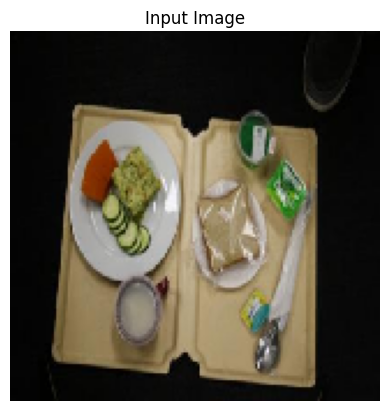

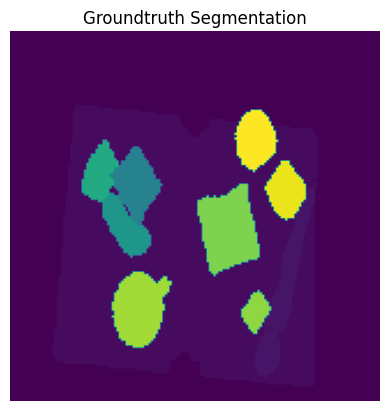

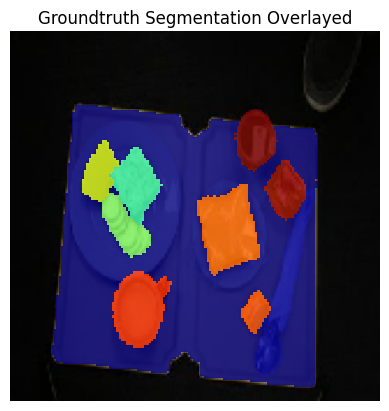

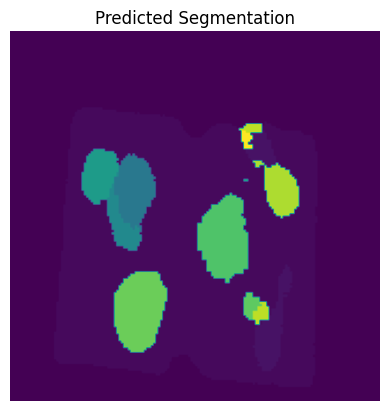

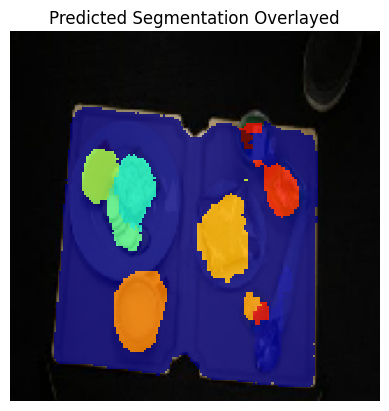

In [206]:
# solution

n_img = 5

# Display input image #7
plt.imshow(val_gen[n_img][0][0].astype(int))
plt.title("Input Image")
plt.axis('off')
plt.show()

# Display groundtruth segmentation #7
plt.imshow(test_mask[n_img])
plt.title("Groundtruth Segmentation")
plt.axis('off')
plt.show()

# Display groundtruth segmentation overlayed on input image #7
def mask_overlay(image, mask):
    """
    Helper function to visualize mask overlay on the image.
    """
    mask = np.ma.masked_where(mask == 0, mask)
    plt.imshow(image, "gray")
    plt.imshow(mask, "jet", interpolation="none", alpha=0.8)
    plt.axis("off")

mask_overlay(val_gen[n_img][0][0].astype(int), test_mask[n_img])
plt.title("Groundtruth Segmentation Overlayed")
plt.axis('off')
plt.show()

# Display predicted segmentation #7
plt.imshow(preds_argmax[n_img].astype(int))
plt.title("Predicted Segmentation")
plt.axis('off')
plt.show()

# Display predicted segmentation overlayed on input image #7
mask_overlay(val_gen[n_img][0][0].astype(int), preds_argmax[n_img])
plt.title("Predicted Segmentation Overlayed")
plt.axis('off')
plt.show()



*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

**Solution**

*   What are other evaluation metrics to compare the performance of segmentation?

    *  The other evaluation metrics to compare the performance of segmentation are Dice Coefficient, Intersection over Union (IoU), Precision, Recall, F1 Score, Accuracy, Mean Intersection over Union (mIoU), Mean Average Precision (mAP), Mean Average Recall (mAR), Mean Average F1 Score (mAF1), Mean Average Accuracy (mAA), Mean Average Dice Coefficient (mADC), Mean Average Intersection over Union (mAIoU), Mean Average Precision (mAP), Mean Average Recall (mAR), Mean Average F1 Score (mAF1), Mean Average Accuracy (mAA).

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

5/5 [==============================] - 0s 43ms/step


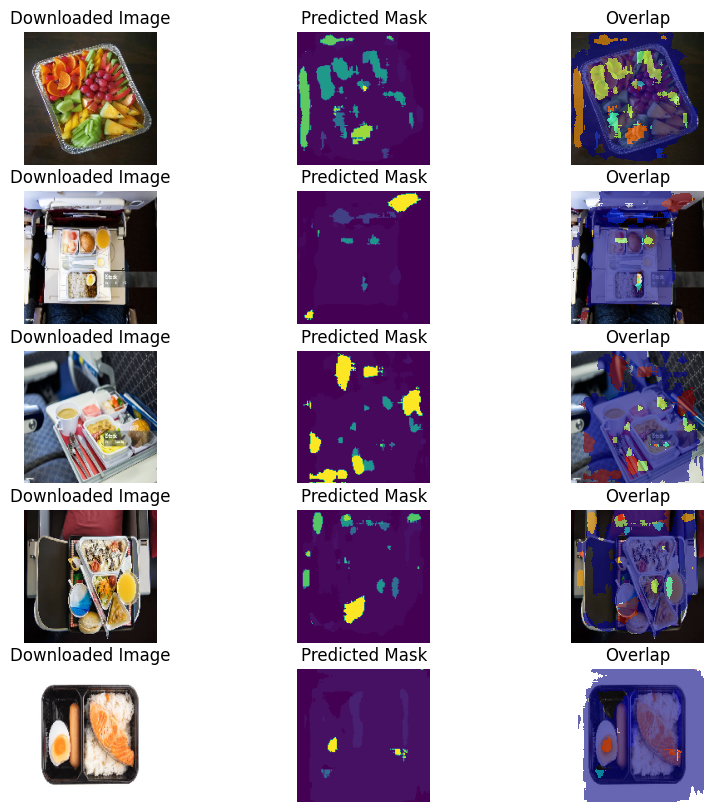

In [224]:
# solution
batch_size = 1  # we define batch_size as 1 for inferencing

internet_img = "/content/drive/MyDrive/P11_image_segmentation/internet/"
internet_paths = sorted(
    [
        os.path.join(internet_img, fname)
        for fname in os.listdir(internet_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)


int_gen = ImageGenerator(batch_size, img_size, internet_paths, internet_paths)

int_preds = model.predict(int_gen)
int_argmax = np.argmax(int_preds, axis=-1)

fig, ax = plt.subplots(len(internet_paths), 3, figsize=(10, 10))

for i in range(len(internet_paths)):
    orig_pic = int_gen[i][0][0].astype(int)
    pred_mask = int_argmax[i]

    ax[i, 0].imshow(orig_pic)
    ax[i, 0].axis("off")
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i,0].set_title("Downloaded Image")

    ax[i, 1].imshow(pred_mask)
    ax[i, 1].axis("off")
    ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    ax[i, 1].set_title("Predicted Mask")


    mask = np.ma.masked_where(pred_mask == 0, pred_mask)
    ax[i, 2].imshow(orig_pic, "gray")
    ax[i, 2].imshow(mask, "jet", interpolation="none", alpha=0.6)
    ax[i, 2].axis("off")
    ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])
    ax[i, 2].set_title("Overlap")




*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

*   How accurate are the prediction masks?

    *  The prediction masks are not accurate. The prediction masks are not accurate because the model is trained on a different dataset and the images from the internet are different from the dataset used.

*   What happens to the unlabelled classes?

    * The unlabelled classes are not predicted by the model. The unlabelled classes are not predicted by the model because the model is trained on a different dataset and the images from the internet are different from the dataset used.

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

Deploying a trained model in the real world poses challenges such as variations in data distribution, adaptability to unforeseen inputs, and ethical concerns related to biases and privacy. To develop a model suitable for real-world use, it is crucial to train it on diverse and representative data, ensuring robustness.

Regular updates with new data help the model adapt to changing environments and maintain relevancy. Additionally, incorporating ethical guidelines in both data collection and model design is essential to address fairness and privacy issues, ensuring responsible deployment and use in practical scenarios.

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

Instance segmentation involves identifying and delineating individual objects within an image, providing a pixel-level mask for each distinct object instance. On the other hand, semantic segmentation focuses on classifying and segmenting regions of an image into different semantic categories, assigning each pixel to a specific class without distinguishing between instances of the same class. In essence, instance segmentation provides a more granular understanding by separating distinct object instances, while semantic segmentation groups pixels based on shared semantic characteristics.

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**
An encoder and a decoder are components in neural networks, especially in architectures like autoencoders and sequence-to-sequence models. The encoder processes input data and transforms it into a compressed representation, often a latent space. The decoder, on the other hand, reconstructs the original input or generates an output from this compressed representation.

While encoders and decoders can be of the same or similar neural network type, they don't have to be identical. In many cases, they serve different purposes and may have different architectures. For example, in variational autoencoders, the encoder and decoder are often symmetric, but this isn't a strict requirement. The choice depends on the specific task and design goals, and the networks can be tailored differently to suit the characteristics of the input and output data.

*   What is upsampling?

**Solution**

**Upsampling** is a technique used in various machine learning and computer vision tasks to increase the spatial dimensions of an image or feature map. It involves enlarging the size of an image or tensor, typically by inserting new elements or replicating existing ones. Upsampling is often employed in the decoder part of neural network architectures, such as in image segmentation or generative models, to recover spatial information lost during downsampling. Common upsampling methods include nearest-neighbor interpolation, bilinear interpolation, or more complex techniques like transposed convolutions (also known as deconvolutions) and subpixel convolutions. The goal is to enhance the resolution of the data, allowing the model to make more detailed predictions or generate higher-resolution outputs.

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

In UNet, feature channels represent the dimensions in the feature maps generated by the convolutional layers. This architecture consists of a contracting encoder and an expanding decoder. The encoder captures contextual information by reducing spatial dimensions and increasing the number of feature channels. This allows the model to understand the global context of the input image. On the other hand, the decoder uses feature channels to recover spatial information and precisely localize objects. The skip connections, connecting encoder features to corresponding decoder layers, aid in combining high-level semantic information with detailed low-level features, ensuring accurate segmentation. Ultimately, feature channels in UNet contribute to a holistic approach, incorporating both global and local information for improved image segmentation.

*   What are some applications of U-Net?

**Solution**

U-Net has found diverse applications across several domains due to its effectiveness in image segmentation tasks. In the realm of biomedical imaging, it is widely utilized for tasks such as organ segmentation, tumor detection, and cell instance segmentation. The architecture's ability to capture intricate details makes it invaluable for analyzing complex structures within medical images.

In the context of satellite image analysis, U-Net plays a key role in land cover classification, urban area mapping, and infrastructure monitoring. Its capacity to extract meaningful information from high-resolution satellite imagery contributes to improved geospatial analysis.

Facial image analysis benefits from U-Net as well, with applications in facial feature segmentation, facial landmark detection, and expression recognition. In the field of autonomous vehicles, U-Net is applied for semantic segmentation of road scenes, aiding in the identification and delineation of objects crucial for safe navigation.

In industrial settings, U-Net is employed for tasks such as defect detection and quality control in manufacturing processes. It helps in identifying and classifying defects in images of products or components, contributing to enhanced quality assurance.

Moreover, U-Net has proven valuable in agricultural field monitoring, where it assists in crop segmentation to identify crops, weeds, and soil. This information is instrumental in optimizing farming practices and promoting precision agriculture.

Beyond these specific applications, U-Net serves as a versatile tool in computer vision for general semantic segmentation tasks, including scene understanding, object recognition, and image annotation. Its adaptability and effectiveness in capturing both global context and fine details make it a widely adopted architecture in various image analysis domains.

*   What are the other popular semantic segmentation algorithms?
*   How are they different from each other?

**Solution**

Several popular semantic segmentation algorithms exist alongside U-Net, each with unique characteristics. One notable approach is the **DeepLab** series, which employs atrous convolution to capture multi-scale contextual information efficiently. DeepLab utilizes dilated convolutions to increase the receptive field without downsampling, enabling precise segmentation.

Another widely used algorithm is **SegNet**, which focuses on leveraging encoder-decoder architectures for real-time segmentation. SegNet employs max-pooling indices during encoding and uses these indices for precise upsampling in the decoding phase, making it computationally efficient.

The **FCN (Fully Convolutional Network)** architecture is fundamental in semantic segmentation. It introduces skip connections to combine coarse and fine-grained features, enabling better localization. FCN popularized the concept of end-to-end trainable networks for segmentation tasks.

**Mask R-CNN** integrates object detection and instance segmentation, extending the Faster R-CNN framework. It introduces a parallel branch for segmentation masks, enabling the model to identify and delineate individual instances of objects within an image.

The **PSPNet (Pyramid Scene Parsing Network)** incorporates a pyramid pooling module to capture global context information at multiple scales. It enhances segmentation performance by aggregating contextual information effectively.

**ENet (Efficient Neural Network for Real-time Semantic Segmentation)** is notable for its lightweight architecture designed for real-time applications. It achieves efficiency through factorized convolutions and a compact design while maintaining competitive segmentation performance.

Differences among these algorithms lie in their architectural designs, receptive field strategies, computational efficiency, and how they handle contextual information. Some emphasize real-time processing, while others focus on capturing intricate details or incorporating object detection. Understanding these distinctions is crucial for selecting the most suitable algorithm based on the specific requirements of a semantic segmentation task.

*   What are the popular semantic segmentation datasets which are available for public access?

**Solution**

Several popular semantic segmentation datasets are publicly available, facilitating the development and evaluation of algorithms. The **Cityscapes** dataset is a widely used resource for urban scene understanding, offering high-resolution images of city streets with pixel-level annotations for various object classes such as vehicles, pedestrians, and buildings.

**PASCAL VOC (Visual Object Classes)** is a benchmark dataset that includes images from a diverse set of scenes and objects. It provides segmentation masks for 20 object classes, making it a valuable resource for evaluating the performance of semantic segmentation models.

The **ADE20K** dataset focuses on diverse scenes and includes over 20,000 images with pixel-wise annotations for 150 object categories. This dataset is useful for training models that need to handle a broad range of semantic segmentation challenges.

**COCO (Common Objects in Context)** is a comprehensive dataset that originally focuses on object detection but also provides segmentation masks for object instances. With a large number of images and diverse scenes, COCO is valuable for evaluating models on various visual contexts.

The **CamVid** dataset is designed for semantic segmentation in the context of autonomous driving. It offers images captured from a vehicle's perspective, annotated with pixel-level labels for road scenes and objects.

These datasets vary in terms of scene complexity, object diversity, and annotation granularity, providing a range of challenges for evaluating the performance of semantic segmentation models. Researchers and practitioners often leverage these datasets to benchmark and compare the effectiveness of different algorithms in addressing real-world segmentation tasks.


---

## **End of P11 (2): Image Segmentation using UNet**